<a href="https://colab.research.google.com/github/pandu1992/PPB_Research/blob/main/SINTA_adaptive_fuel_subsidy_simulation_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cpu device


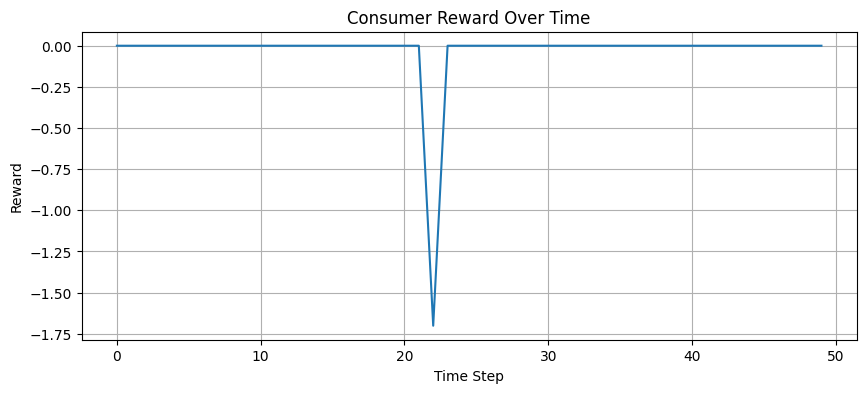

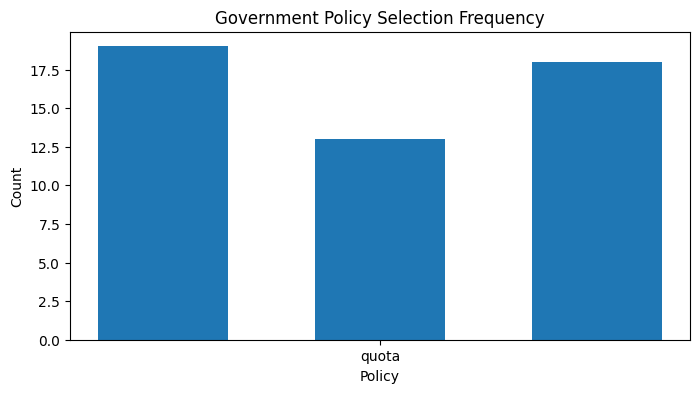

In [ ]:
# Adaptive Fuel Subsidy Simulation (DQN + Bandit) - Colab Ready

# Install required libraries
!pip install stable-baselines3[extra] gymnasium matplotlib

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt

# Define the custom environment
class FuelConsumptionEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_quota = 50
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        # Use a discrete action space with 10 possible actions (0-9)
        self.action_space = spaces.Discrete(10)

    def reset(self, seed=None, options=None):
        self.income = np.random.rand()
        self.last_demand = np.random.rand()
        self.price = 0.5
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        # Map the discrete action to a fuel demand percentage
        demand = (action / (self.action_space.n - 1)) * self.max_quota
        cost = demand * self.price
        reward = self.income * demand - cost
        self.last_demand = demand
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, reward, False, False, {}


# Create and train the DQN agent
env = make_vec_env(lambda: FuelConsumptionEnv(), n_envs=1)
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Define the government bandit agent
class GovernmentBanditAgent:
    def __init__(self):
        self.arms = ["universal", "quota", "targeted"]
        self.counts = [1] * len(self.arms)
        self.values = [0.0] * len(self.arms)

    def select_arm(self):
        total = sum(self.counts)
        ucb = [v + np.sqrt(2 * np.log(total) / c) for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

# Run simulation loop
env_instance = FuelConsumptionEnv()
gov = GovernmentBanditAgent()

reward_log = []
policy_log = []

for t in range(50):
    state, _ = env_instance.reset()
    arm = gov.select_arm()
    policy_log.append(gov.arms[arm])
    action, _ = model.predict(state)
    _, reward, _, _, _ = env_instance.step(action)
    reward_log.append(reward)
    gov.update(arm, reward)

# Visualize results
plt.figure(figsize=(10, 4))
plt.plot(reward_log)
plt.title("Consumer Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(policy_log, bins=3, rwidth=0.6)
plt.title("Government Policy Selection Frequency")
plt.xlabel("Policy")
plt.ylabel("Count")
plt.show()


Using cpu device


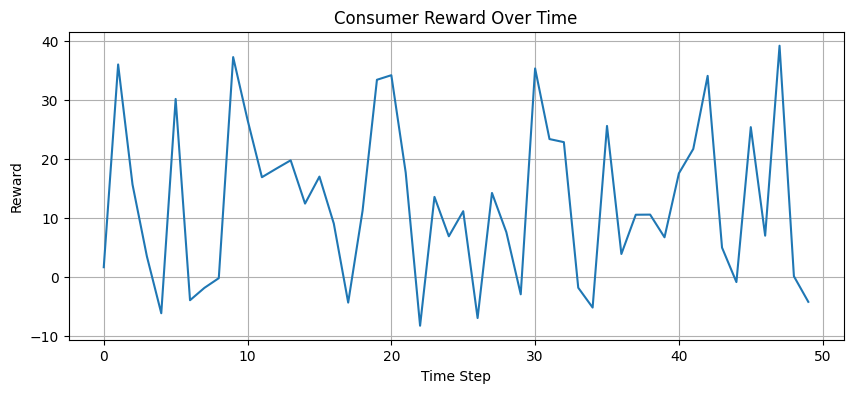

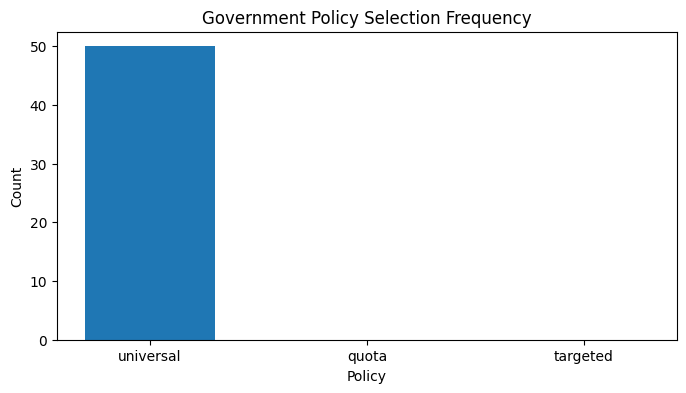

In [ ]:
# Adaptive Fuel Subsidy Simulation (Improved: DQN + Bandit + Policy Effects)
!pip install stable-baselines3[extra] gymnasium matplotlib

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt

# Custom environment with government policy effect
class FuelConsumptionEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_quota = 50
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(10)  # 0–9

    def reset(self, seed=None, options=None):
        self.income = np.random.rand()
        self.last_demand = np.random.rand()
        self.price = 0.5  # base price
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, {}

    def step(self, action, policy=None):
        # Apply subsidy discount
        subsidy_discount = {
            "universal": 0.3,
            "quota": 0.2 if self.last_demand <= 25 else 0.0,
            "targeted": 0.4 if self.income < 0.5 else 0.0
        }.get(policy, 0.0)

        effective_price = max(0.1, self.price - subsidy_discount)

        # Translate action to demand (0–50 liters)
        demand = (action / (self.action_space.n - 1)) * self.max_quota
        cost = demand * effective_price
        reward = self.income * demand - cost

        # Strategic penalty for hoarding in quota-based policy
        if policy == "quota" and demand > 30:
            reward -= 0.5

        self.last_demand = demand
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, reward, False, False, {}

# Train the DQN agent
env = make_vec_env(lambda: FuelConsumptionEnv(), n_envs=1)
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Bandit-based government agent
class GovernmentBanditAgent:
    def __init__(self):
        self.arms = ["universal", "quota", "targeted"]
        self.counts = [1] * len(self.arms)
        self.values = [0.0] * len(self.arms)

    def select_arm(self):
        total = sum(self.counts)
        ucb = [v + np.sqrt(2 * np.log(total) / c) for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

# Run simulation
env_instance = FuelConsumptionEnv()
gov = GovernmentBanditAgent()

reward_log = []
policy_log = []

for t in range(50):
    state, _ = env_instance.reset()
    arm = gov.select_arm()
    policy = gov.arms[arm]
    policy_log.append(policy)

    action, _ = model.predict(state)
    _, reward, _, _, _ = env_instance.step(action, policy=policy)

    reward_log.append(reward)
    gov.update(arm, reward)

# Visualize results
plt.figure(figsize=(10, 4))
plt.plot(reward_log)
plt.title("Consumer Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(policy_log, bins=np.arange(4)-0.5, rwidth=0.6)
plt.xticks([0, 1, 2], gov.arms)
plt.title("Government Policy Selection Frequency")
plt.xlabel("Policy")
plt.ylabel("Count")
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

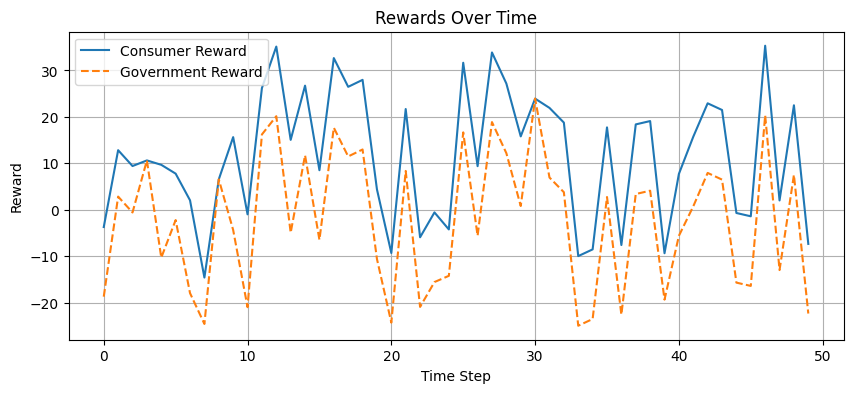

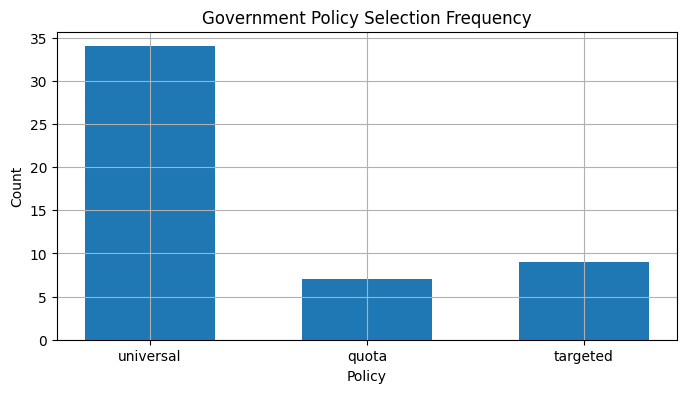

In [3]:
# Adaptive Fuel Subsidy Simulation (Final Version with Exploration & Realistic Reward)
!pip install stable-baselines3[extra] gymnasium matplotlib

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt

# Custom environment with policy effect
class FuelConsumptionEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_quota = 50
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(10)

    def reset(self, seed=None, options=None):
        self.income = np.random.rand()
        self.last_demand = np.random.rand()
        self.price = 0.5
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, {}

    def step(self, action, policy=None):
        subsidy_discount = {
            "universal": 0.3,
            "quota": 0.2 if self.last_demand <= 25 else 0.0,
            "targeted": 0.4 if self.income < 0.5 else 0.0
        }.get(policy, 0.0)

        effective_price = max(0.1, self.price - subsidy_discount)
        demand = (action / (self.action_space.n - 1)) * self.max_quota
        cost = demand * effective_price
        reward = self.income * demand - cost

        # Simulate hoarding behavior
        if policy == "quota" and demand > 30:
            reward -= 0.5

        # Save for external calculation
        self.last_demand = demand
        self.last_discount = subsidy_discount
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, reward, False, False, {}

# Train consumer DQN agent
env = make_vec_env(lambda: FuelConsumptionEnv(), n_envs=1)
model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000)

# Government bandit agent with ε-greedy
class GovernmentBanditAgent:
    def __init__(self):
        self.arms = ["universal", "quota", "targeted"]
        self.counts = [1] * len(self.arms)
        self.values = [0.0] * len(self.arms)

    def select_arm(self, epsilon=0.2):
        if np.random.rand() < epsilon:
            return np.random.randint(len(self.arms))  # explore
        total = sum(self.counts)
        ucb = [v + np.sqrt(2 * np.log(total) / c) for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb)  # exploit

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

# Simulation loop
env_instance = FuelConsumptionEnv()
gov = GovernmentBanditAgent()

reward_log = []
gov_reward_log = []
policy_log = []

for t in range(50):
    state, _ = env_instance.reset()
    arm = gov.select_arm(epsilon=0.2)
    policy = gov.arms[arm]
    policy_log.append(policy)

    action, _ = model.predict(state)
    _, reward, _, _, _ = env_instance.step(action, policy=policy)

    # Calculate government reward (reward to people - subsidy cost)
    subsidy_cost = env_instance.last_demand * env_instance.last_discount
    gov_reward = reward - subsidy_cost

    reward_log.append(reward)
    gov_reward_log.append(gov_reward)
    gov.update(arm, gov_reward)

# Plot reward to consumers
plt.figure(figsize=(10, 4))
plt.plot(reward_log, label="Consumer Reward")
plt.plot(gov_reward_log, label="Government Reward", linestyle="--")
plt.title("Rewards Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Plot policy selection frequency
plt.figure(figsize=(8, 4))
plt.hist(policy_log, bins=np.arange(4)-0.5, rwidth=0.6)
plt.xticks([0, 1, 2], gov.arms)
plt.title("Government Policy Selection Frequency")
plt.xlabel("Policy")
plt.ylabel("Count")
plt.grid()
plt.show()

[Step 100] Avg Reward (last 100): 6.27, Gov Reward: -1.94
[Step 200] Avg Reward (last 100): 6.19, Gov Reward: -1.16
[Step 300] Avg Reward (last 100): 8.67, Gov Reward: 0.10
[Step 400] Avg Reward (last 100): 8.22, Gov Reward: 0.53
[Step 500] Avg Reward (last 100): 7.77, Gov Reward: -0.11
[Step 600] Avg Reward (last 100): 6.99, Gov Reward: -0.72
[Step 700] Avg Reward (last 100): 8.01, Gov Reward: 0.46
[Step 800] Avg Reward (last 100): 7.41, Gov Reward: 0.61
[Step 900] Avg Reward (last 100): 7.39, Gov Reward: -2.84
[Step 1000] Avg Reward (last 100): 6.87, Gov Reward: -1.54


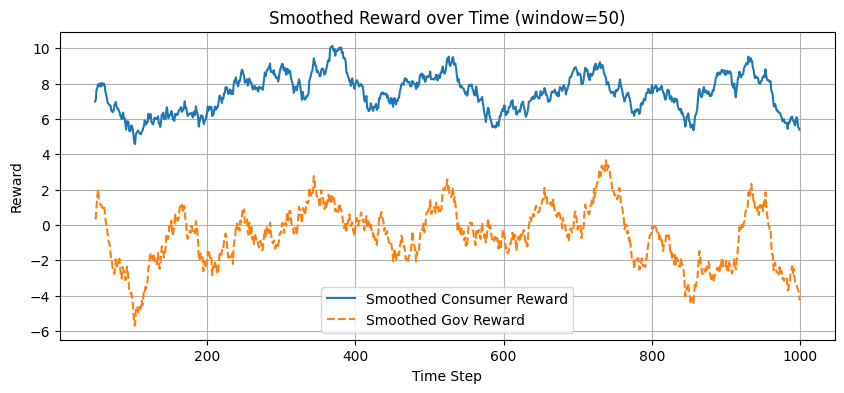

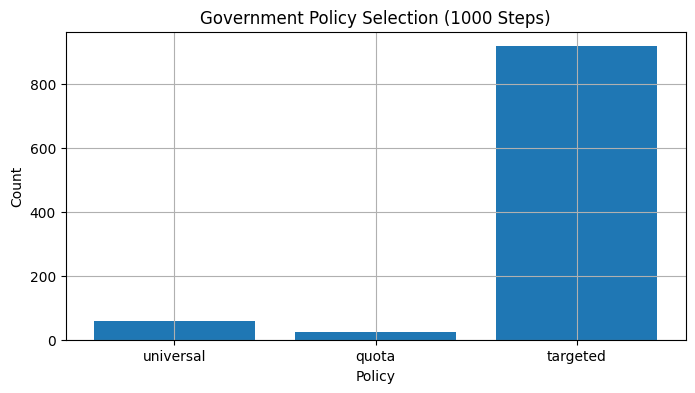

In [4]:
# Adaptive Fuel Subsidy Simulation (with 1000+ Iterations, Logging & Smoothed Plot)
!pip install stable-baselines3[extra] gymnasium matplotlib

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# --- ENVIRONMENT ---
class FuelConsumptionEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_quota = 50
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(10)

    def reset(self, seed=None, options=None):
        self.income = np.random.rand()
        self.last_demand = np.random.rand()
        self.price = 0.5
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, {}

    def step(self, action, policy=None):
        subsidy_discount = {
            "universal": 0.3,
            "quota": 0.2 if self.last_demand <= 25 else 0.0,
            "targeted": 0.4 if self.income < 0.5 else 0.0
        }.get(policy, 0.0)

        effective_price = max(0.1, self.price - subsidy_discount)
        demand = (action / (self.action_space.n - 1)) * self.max_quota
        cost = demand * effective_price
        reward = self.income * demand - cost

        if policy == "quota" and demand > 30:
            reward -= 0.5

        self.last_demand = demand
        self.last_discount = subsidy_discount
        self.state = np.array([self.income, self.last_demand, self.price], dtype=np.float32)
        return self.state, reward, False, False, {}

# --- DQN AGENT (Consumer) ---
env = make_vec_env(lambda: FuelConsumptionEnv(), n_envs=1)
model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000)

# --- BANDIT AGENT (Government) ---
class GovernmentBanditAgent:
    def __init__(self):
        self.arms = ["universal", "quota", "targeted"]
        self.counts = [1] * len(self.arms)
        self.values = [0.0] * len(self.arms)

    def select_arm(self, epsilon=0.1):  # 10% eksplorasi
        if np.random.rand() < epsilon:
            return np.random.randint(len(self.arms))
        total = sum(self.counts)
        ucb = [v + np.sqrt(2 * np.log(total) / c) for v, c in zip(self.values, self.counts)]
        return np.argmax(ucb)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

# --- SIMULASI LOOP 1000 ITERASI ---
env_instance = FuelConsumptionEnv()
gov = GovernmentBanditAgent()

reward_log = []
gov_reward_log = []
policy_log = []

EVALUATION_INTERVAL = 100

for t in range(1000):
    state, _ = env_instance.reset()
    arm = gov.select_arm(epsilon=0.1)
    policy = gov.arms[arm]
    policy_log.append(policy)

    action, _ = model.predict(state)
    _, reward, _, _, _ = env_instance.step(action, policy=policy)

    subsidy_cost = env_instance.last_demand * env_instance.last_discount
    gov_reward = reward - subsidy_cost

    reward_log.append(reward)
    gov_reward_log.append(gov_reward)
    gov.update(arm, gov_reward)

    if (t + 1) % EVALUATION_INTERVAL == 0:
        print(f"[Step {t+1}] Avg Reward (last {EVALUATION_INTERVAL}): "
              f"{np.mean(reward_log[-EVALUATION_INTERVAL:]):.2f}, "
              f"Gov Reward: {np.mean(gov_reward_log[-EVALUATION_INTERVAL:]):.2f}")

# --- PLOTTING ---

# Smoothed reward
plt.figure(figsize=(10, 4))
pd.Series(reward_log).rolling(window=50).mean().plot(label="Smoothed Consumer Reward")
pd.Series(gov_reward_log).rolling(window=50).mean().plot(label="Smoothed Gov Reward", linestyle="--")
plt.title("Smoothed Reward over Time (window=50)")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.grid()
plt.legend()
plt.show()

# Policy selection
plt.figure(figsize=(8, 4))
counter = Counter(policy_log)
plt.bar(counter.keys(), counter.values())
plt.title("Government Policy Selection (1000 Steps)")
plt.xlabel("Policy")
plt.ylabel("Count")
plt.grid()
plt.show()


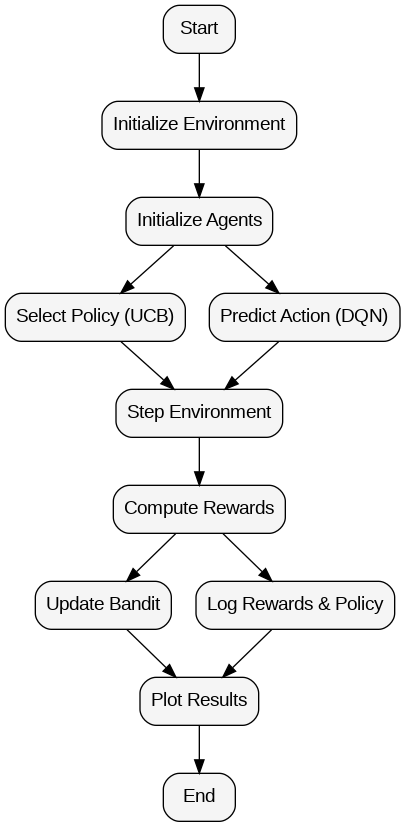

In [5]:
# Install Graphviz if not already installed
# !apt-get install graphviz
# !pip install graphviz

import graphviz
from IPython.display import Image, display

# Build flowchart
dot = graphviz.Digraph(format='png')
dot.attr(rankdir='TB', size='8,10')
dot.attr('node', shape='box', style='rounded,filled', color='black', fillcolor='whitesmoke', fontname='Helvetica')

# Define process blocks
dot.node('Start', 'Start')
dot.node('InitEnv', 'Initialize Environment')
dot.node('InitAgents', 'Initialize Agents')
dot.node('SelectPolicy', 'Select Policy (UCB)')
dot.node('PredictAction', 'Predict Action (DQN)')
dot.node('StepEnv', 'Step Environment')
dot.node('ComputeRewards', 'Compute Rewards')
dot.node('UpdateBandit', 'Update Bandit')
dot.node('LogPolicy', 'Log Rewards & Policy')
dot.node('PlotResults', 'Plot Results')
dot.node('End', 'End')

# Create edges to form the pipeline
dot.edge('Start', 'InitEnv')
dot.edge('InitEnv', 'InitAgents')
dot.edge('InitAgents', 'SelectPolicy')
dot.edge('InitAgents', 'PredictAction')
dot.edge('SelectPolicy', 'StepEnv')
dot.edge('PredictAction', 'StepEnv')
dot.edge('StepEnv', 'ComputeRewards')
dot.edge('ComputeRewards', 'UpdateBandit')
dot.edge('ComputeRewards', 'LogPolicy')
dot.edge('UpdateBandit', 'PlotResults')
dot.edge('LogPolicy', 'PlotResults')
dot.edge('PlotResults', 'End')

# Save and display inline
flowchart_path = dot.render('adaptive_subsidy_flowchart')
display(Image(filename=flowchart_path))


In [9]:
from scipy import stats
from collections import Counter

# --- EVALUATION METRICS ---

# Calculate average rewards for each policy type
universal_rewards = [reward for reward, policy in zip(reward_log, policy_log) if policy == 'universal']
quota_rewards = [reward for reward, policy in zip(reward_log, policy_log) if policy == 'quota']
targeted_rewards = [reward for reward, policy in zip(reward_log, policy_log) if policy == 'targeted']

# Calculate overall average rewards
avg_consumer_reward = np.mean(reward_log)
avg_government_reward = np.mean(gov_reward_log)

# Calculate policy selection frequency
policy_counts = Counter(policy_log)

# Perform ANOVA to compare the average rewards across the three policies
# Filter out empty lists for ANOVA
anova_data = [rewards for rewards in [universal_rewards, quota_rewards, targeted_rewards] if rewards]
if len(anova_data) >= 2: # ANOVA requires at least two groups
    f_stat, p_value = stats.f_oneway(*anova_data)
else:
    f_stat = np.nan
    p_value = np.nan


# Display evaluation matrix and ANOVA result
print("\n--- Evaluation Matrix ---")
print(f"Average Consumer Reward: {avg_consumer_reward:.2f}")
print(f"Average Government Reward: {avg_government_reward:.2f}")
print("Policy Selection Frequency:")
for policy, count in policy_counts.items():
    print(f"{policy}: {count}")

# ANOVA Results
print("\n--- ANOVA Test ---")
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of the result
if not np.isnan(p_value):
    if p_value < 0.05:
        print("There is a significant difference between the rewards of the three policies.")
    else:
        print("There is no significant difference between the rewards of the three policies.")
else:
    print("ANOVA test could not be performed with less than two policy types selected.")


--- Evaluation Matrix ---
Average Consumer Reward: 7.38
Average Government Reward: -0.66
Policy Selection Frequency:
universal: 59
quota: 25
targeted: 916

--- ANOVA Test ---
F-statistic: 3.79
P-value: 0.0229
There is a significant difference between the rewards of the three policies.
